In [22]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Для сохранения графиков
import os

# Предобработка
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Метрики качества кластеризации (внутренние)
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Для проверки устойчивости
from sklearn.metrics import adjusted_rand_score

# Понижение размерности для визуализации
from sklearn.decomposition import PCA

# Для подбора параметров (например, график k-distance для DBSCAN)
from sklearn.neighbors import NearestNeighbors

# Для работы с JSON (сохранение артефактов)
import json

# HW07: Кластеризация

## Цель работы
Закрепить понимание методов кластеризации (KMeans, DBSCAN, Agglomerative), препроцессинга для distance-based методов и оценки качества кластеризации без истинных меток.

## Выбранные датасеты
1. **S07-hw-dataset-01.csv** - Числовые признаки в разных шкалах + шумовые признаки
2. **S07-hw-dataset-02.csv** - Нелинейная структура + выбросы + шумовой признак
3. **S07-hw-dataset-03.csv** - Кластеры разной плотности + фоновый шум


In [23]:
# Настройки путей
DATA_DIR = "data/"
ARTIFACTS_DIR = "artifacts/"
FIGURES_DIR = "artifacts/figures/"

# Создание директорий если их нет
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(f"{ARTIFACTS_DIR}labels/", exist_ok=True)

# Настройки визуализации
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Фиксация random_state для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


---
# Dataset 1: S07-hw-dataset-01.csv

## Описание
Числовые признаки в разных шкалах + шумовые признаки. Без масштабирования результаты обычно "едут".

## 1.1 Загрузка данных и первичный анализ


In [24]:
# Загрузка Dataset 1
df1 = pd.read_csv(f"{DATA_DIR}S07-hw-dataset-01.csv")

print("=" * 60)
print("DATASET 1: S07-hw-dataset-01.csv")
print("=" * 60)
print(f"\nРазмер датасета: {df1.shape[0]} строк, {df1.shape[1]} столбцов")

# Первые строки
print("\n--- HEAD ---")
df1.head(10)


DATASET 1: S07-hw-dataset-01.csv

Размер датасета: 12000 строк, 9 столбцов

--- HEAD ---


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213
5,5,-9.155108,80.803958,-0.023064,-42.562391,2.681999,-10.450216,52.285727,0.134157
6,6,-13.414198,-45.224459,0.016343,23.198649,0.275342,4.845267,40.734814,0.040547
7,7,-15.303931,-39.539061,0.198038,21.117504,0.334350,1.308574,17.347164,0.378773
8,8,-15.154668,-34.099503,0.215049,18.059247,1.937555,2.834771,-87.429349,-0.191803
9,9,0.673476,-82.966506,-0.066941,70.082996,-11.262309,-7.221289,-28.222359,-0.383327


In [25]:
# Информация о типах данных
print("--- INFO ---")
df1.info()
print("\n")

# Проверка пропусков
print("--- ПРОПУСКИ ---")
missing = df1.isnull().sum()
missing_pct = (missing / len(df1) * 100).round(2)
missing_df = pd.DataFrame({'Пропусков': missing, 'Процент': missing_pct})
print(missing_df)
print(f"\nВсего пропусков: {missing.sum()}")


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


--- ПРОПУСКИ ---
           Пропусков  Процент
sample_id          0      0.0
f01                0      0.0
f02                0      0.0
f03                0      0.0
f04                0      0.0
f05                0      0.0
f06                0      0.0
f07                0      0.0
f08                0      0.0

Всего пропусков: 0


In [26]:
# Базовые статистики
print("--- DESCRIBE ---")
df1.describe().T


--- DESCRIBE ---


,count,mean,std,min,25%,50%,75%,max
sample_id,12000.0,5999.500000,3464.245950,0.000000,2999.750000,5999.500000,8999.250000,11999.000000
f01,12000.0,-2.424716,11.014315,-19.912573,-9.472623,-6.869404,0.523841,24.403381
f02,12000.0,19.107804,60.790338,-92.892652,-40.282955,54.069335,70.280739,112.229523
f03,12000.0,-0.222063,0.500630,-1.590979,-0.125145,-0.031753,0.054980,0.512277
f04,12000.0,-8.284501,59.269838,-134.303679,-48.345007,16.211728,28.067178,75.088604
f05,12000.0,-0.190717,7.026435,-11.869169,-5.132473,0.444730,3.942368,13.717091
f06,12000.0,0.962972,14.794713,-20.521164,-8.807706,-6.134169,2.334426,41.452857
f07,12000.0,0.033724,59.541782,-215.098834,-39.900520,-0.578494,39.719821,213.381767
f08,12000.0,0.007638,0.607053,-2.633469,-0.401483,0.005306,0.410132,2.490745


In [27]:
# Разделение sample_id и признаков
sample_id_1 = df1['sample_id']
X1 = df1.drop(columns=['sample_id'])

print(f"Признаки (X1): {X1.shape}")
print(f"Типы признаков:\n{X1.dtypes}")
print(f"\nВсе признаки числовые: {X1.select_dtypes(include=[np.number]).shape[1] == X1.shape[1]}")


Признаки (X1): (12000, 8)
Типы признаков:
f01    float64
f02    float64
f03    float64
f04    float64
f05    float64
f06    float64
f07    float64
f08    float64
dtype: object

Все признаки числовые: True


## 1.2 Препроцессинг Dataset 1

**Стратегия:**
- Масштабирование: StandardScaler (обязательно для distance-based методов)
- Пропуски: нет (проверено выше)
- Категориальные признаки: нет (все признаки числовые)


In [28]:
# Препроцессинг Pipeline для Dataset 1
# Все признаки числовые, пропусков нет → только StandardScaler

preprocessor_1 = Pipeline([
    ('scaler', StandardScaler())
])

# Применяем препроцессинг
X1_scaled = preprocessor_1.fit_transform(X1)

print(f"Размер после препроцессинга: {X1_scaled.shape}")
print(f"\nСтатистики после масштабирования (первые 5 признаков):")
print(f"  Mean: {X1_scaled[:, :5].mean(axis=0).round(6)}")
print(f"  Std:  {X1_scaled[:, :5].std(axis=0).round(6)}")


Размер после препроцессинга: (12000, 8)

Статистики после масштабирования (первые 5 признаков):
  Mean: [-0. -0. -0. -0. -0.]
  Std:  [1. 1. 1. 1. 1.]


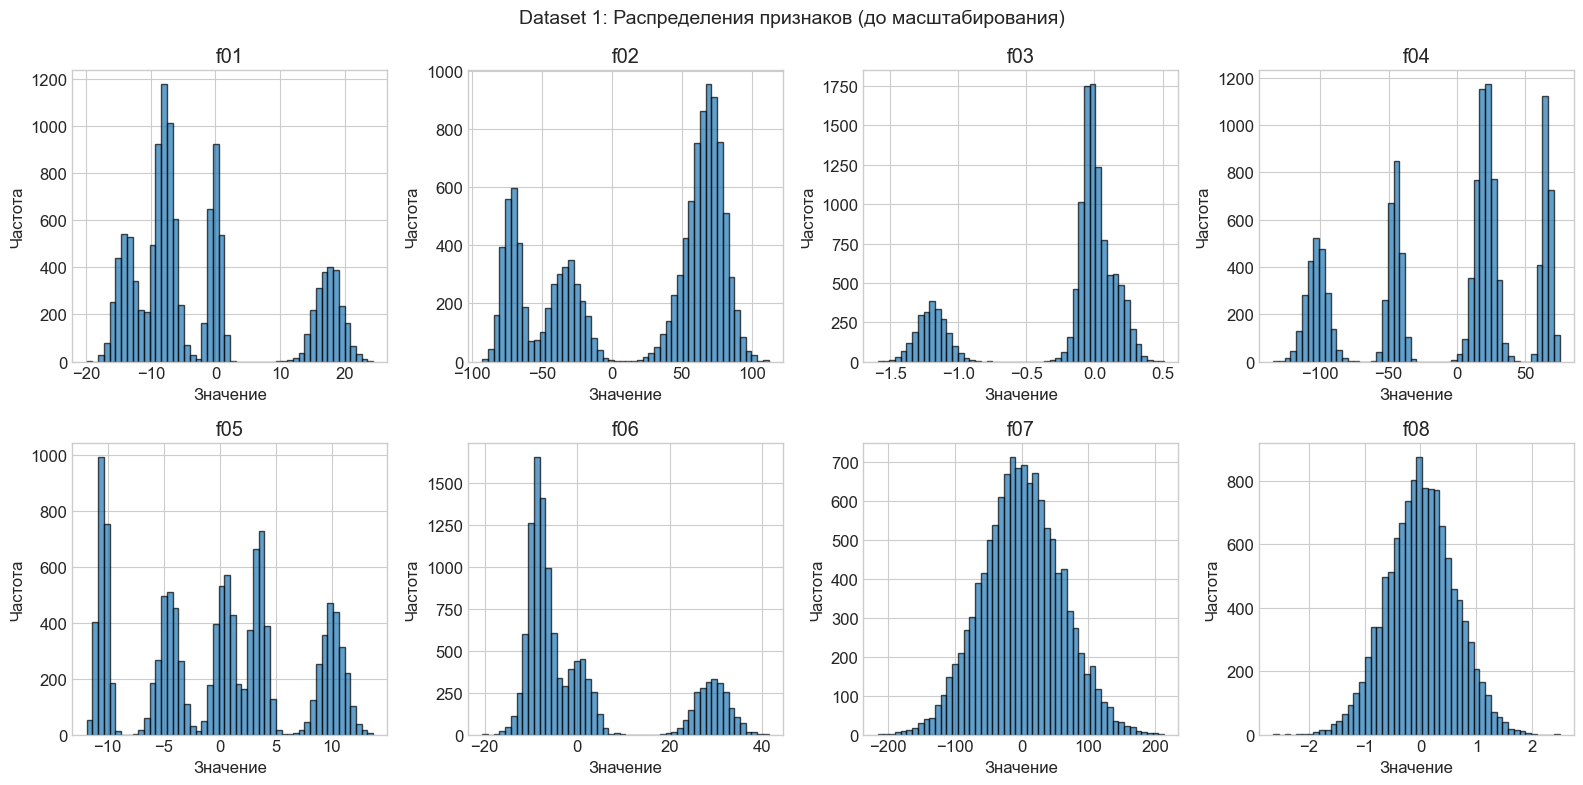

Наблюдение: признаки имеют разные шкалы (от ~(-100, 100) до ~(-1, 1))


In [29]:
# Визуализация распределений признаков до и после масштабирования
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Dataset 1: Распределения признаков (до масштабирования)', fontsize=14)

for i, col in enumerate(X1.columns):
    ax = axes[i // 4, i % 4]
    ax.hist(X1[col], bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel('Значение')
    ax.set_ylabel('Частота')

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}ds1_distributions_original.png", dpi=150, bbox_inches='tight')
plt.show()

print("Наблюдение: признаки имеют разные шкалы (от ~(-100, 100) до ~(-1, 1))")


---
# Dataset 2: S07-hw-dataset-02.csv

## Описание
Нелинейная структура + выбросы + лишний шумовой признак. Хорошо демонстрирует, где KMeans проигрывает.

## 2.1 Загрузка данных и первичный анализ


In [30]:
# Загрузка Dataset 2
df2 = pd.read_csv(f"{DATA_DIR}S07-hw-dataset-02.csv")

print("=" * 60)
print("DATASET 2: S07-hw-dataset-02.csv")
print("=" * 60)
print(f"\nРазмер датасета: {df2.shape[0]} строк, {df2.shape[1]} столбцов")

# Первые строки
print("\n--- HEAD ---")
df2.head(10)


DATASET 2: S07-hw-dataset-02.csv

Размер датасета: 8000 строк, 4 столбцов

--- HEAD ---


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472
5,5,-0.932356,2.894645,-9.150930
6,6,0.117411,0.834173,4.382666
7,7,1.024343,-1.421237,-3.629838
8,8,-0.468618,-0.296113,-9.568211
9,9,-1.231242,-1.213089,-7.716715


In [31]:
# Информация о типах данных
print("--- INFO ---")
df2.info()
print("\n")

# Проверка пропусков
print("--- ПРОПУСКИ ---")
missing2 = df2.isnull().sum()
missing2_pct = (missing2 / len(df2) * 100).round(2)
missing2_df = pd.DataFrame({'Пропусков': missing2, 'Процент': missing2_pct})
print(missing2_df)
print(f"\nВсего пропусков: {missing2.sum()}")


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


--- ПРОПУСКИ ---
           Пропусков  Процент
sample_id          0      0.0
x1                 0      0.0
x2                 0      0.0
z_noise            0      0.0

Всего пропусков: 0


In [32]:
# Базовые статистики
print("--- DESCRIBE ---")
df2.describe().T


--- DESCRIBE ---


,count,mean,std,min,25%,50%,75%,max
sample_id,8000.0,3999.500000,2309.545410,0.000000,1999.750000,3999.500000,5999.250000,7999.000000
x1,8000.0,0.478867,0.955138,-2.487352,-0.116516,0.490658,1.085263,2.987555
x2,8000.0,0.241112,0.663195,-2.499237,-0.242357,0.241092,0.726526,2.995553
z_noise,8000.0,0.110454,8.097716,-34.056074,-5.392210,0.132470,5.655605,29.460076


In [33]:
# Разделение sample_id и признаков
sample_id_2 = df2['sample_id']
X2 = df2.drop(columns=['sample_id'])

print(f"Признаки (X2): {X2.shape}")
print(f"Типы признаков:\n{X2.dtypes}")
print(f"\nВсе признаки числовые: {X2.select_dtypes(include=[np.number]).shape[1] == X2.shape[1]}")
print(f"\nПримечание: z_noise - вероятно шумовой признак (см. описание датасета)")


Признаки (X2): (8000, 3)
Типы признаков:
x1         float64
x2         float64
z_noise    float64
dtype: object

Все признаки числовые: True

Примечание: z_noise - вероятно шумовой признак (см. описание датасета)


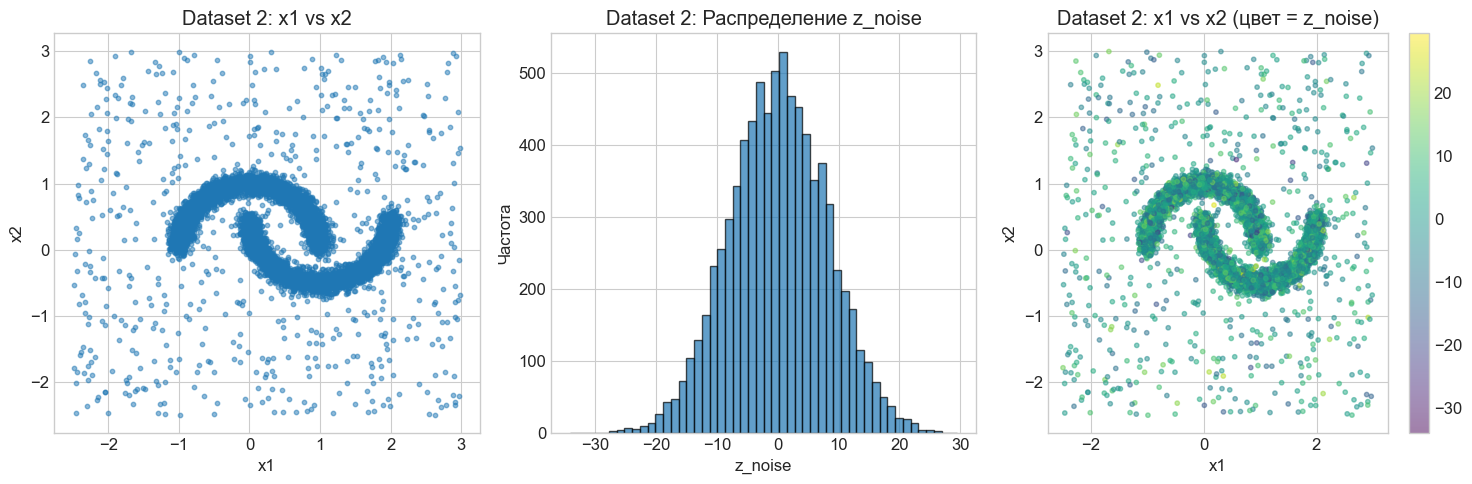

Наблюдение: видна нелинейная структура (возможно, спиральная или кольцевая)


In [34]:
# Визуализация структуры Dataset 2 (x1 vs x2)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter x1 vs x2
axes[0].scatter(X2['x1'], X2['x2'], alpha=0.5, s=10)
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Dataset 2: x1 vs x2')

# Гистограмма z_noise
axes[1].hist(X2['z_noise'], bins=50, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('z_noise')
axes[1].set_ylabel('Частота')
axes[1].set_title('Dataset 2: Распределение z_noise')

# Scatter с раскраской по z_noise
scatter = axes[2].scatter(X2['x1'], X2['x2'], c=X2['z_noise'], cmap='viridis', alpha=0.5, s=10)
axes[2].set_xlabel('x1')
axes[2].set_ylabel('x2')
axes[2].set_title('Dataset 2: x1 vs x2 (цвет = z_noise)')
plt.colorbar(scatter, ax=axes[2])

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}ds2_structure_original.png", dpi=150, bbox_inches='tight')
plt.show()

print("Наблюдение: видна нелинейная структура (возможно, спиральная или кольцевая)")


## 2.2 Препроцессинг Dataset 2

**Стратегия:**
- Масштабирование: StandardScaler (обязательно)
- Пропуски: нет
- Категориальные признаки: нет
- Примечание: z_noise - шумовой признак, но оставляем его (алгоритмы должны справиться)


In [35]:
# Препроцессинг Pipeline для Dataset 2
preprocessor_2 = Pipeline([
    ('scaler', StandardScaler())
])

# Применяем препроцессинг
X2_scaled = preprocessor_2.fit_transform(X2)

print(f"Размер после препроцессинга: {X2_scaled.shape}")
print(f"\nСтатистики после масштабирования:")
print(f"  Mean: {X2_scaled.mean(axis=0).round(6)}")
print(f"  Std:  {X2_scaled.std(axis=0).round(6)}")


Размер после препроцессинга: (8000, 3)

Статистики после масштабирования:
  Mean: [-0.  0. -0.]
  Std:  [1. 1. 1.]


---
# Dataset 3: S07-hw-dataset-03.csv

## Описание
Кластеры разной плотности + фоновый шум. Часто провоцирует ошибки выбора eps для DBSCAN.

## 3.1 Загрузка данных и первичный анализ


In [36]:
# Загрузка Dataset 3
df3 = pd.read_csv(f"{DATA_DIR}S07-hw-dataset-03.csv")

print("=" * 60)
print("DATASET 3: S07-hw-dataset-03.csv")
print("=" * 60)
print(f"\nРазмер датасета: {df3.shape[0]} строк, {df3.shape[1]} столбцов")

# Первые строки
print("\n--- HEAD ---")
df3.head(10)


DATASET 3: S07-hw-dataset-03.csv

Размер датасета: 15000 строк, 5 столбцов

--- HEAD ---


,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899
5,5,-3.742328,1.064578,-0.286082,-0.284744
6,6,-5.610292,9.366270,-2.713613,-0.129379
7,7,3.875465,2.140182,0.722438,-0.269551
8,8,-7.267612,5.822122,-2.962351,-1.237094
9,9,9.415678,6.038169,3.124603,-0.140653


In [37]:
# Информация о типах данных
print("--- INFO ---")
df3.info()
print("\n")

# Проверка пропусков
print("--- ПРОПУСКИ ---")
missing3 = df3.isnull().sum()
missing3_pct = (missing3 / len(df3) * 100).round(2)
missing3_df = pd.DataFrame({'Пропусков': missing3, 'Процент': missing3_pct})
print(missing3_df)
print(f"\nВсего пропусков: {missing3.sum()}")


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


--- ПРОПУСКИ ---
           Пропусков  Процент
sample_id          0      0.0
x1                 0      0.0
x2                 0      0.0
f_corr             0      0.0
f_noise            0      0.0

Всего пропусков: 0


In [38]:
# Базовые статистики
print("--- DESCRIBE ---")
df3.describe().T


--- DESCRIBE ---


,count,mean,std,min,25%,50%,75%,max
sample_id,15000.0,7499.500000,4330.271354,0.000000,3749.750000,7499.500000,11249.250000,14999.000000
x1,15000.0,1.246296,4.592421,-9.995585,-1.782144,0.664226,4.435671,16.207863
x2,15000.0,1.033764,4.710791,-9.980853,-2.666393,1.831257,4.969630,14.271153
f_corr,15000.0,0.212776,1.530017,-5.212038,-0.966224,0.296508,1.390273,5.795876
f_noise,15000.0,-0.027067,2.506375,-8.785884,-1.731128,-0.052391,1.673831,11.266865


In [39]:
# Разделение sample_id и признаков
sample_id_3 = df3['sample_id']
X3 = df3.drop(columns=['sample_id'])

print(f"Признаки (X3): {X3.shape}")
print(f"Типы признаков:\n{X3.dtypes}")
print(f"\nВсе признаки числовые: {X3.select_dtypes(include=[np.number]).shape[1] == X3.shape[1]}")
print(f"\nПримечание: f_corr и f_noise - вероятно, коррелированный и шумовой признаки")


Признаки (X3): (15000, 4)
Типы признаков:
x1         float64
x2         float64
f_corr     float64
f_noise    float64
dtype: object

Все признаки числовые: True

Примечание: f_corr и f_noise - вероятно, коррелированный и шумовой признаки


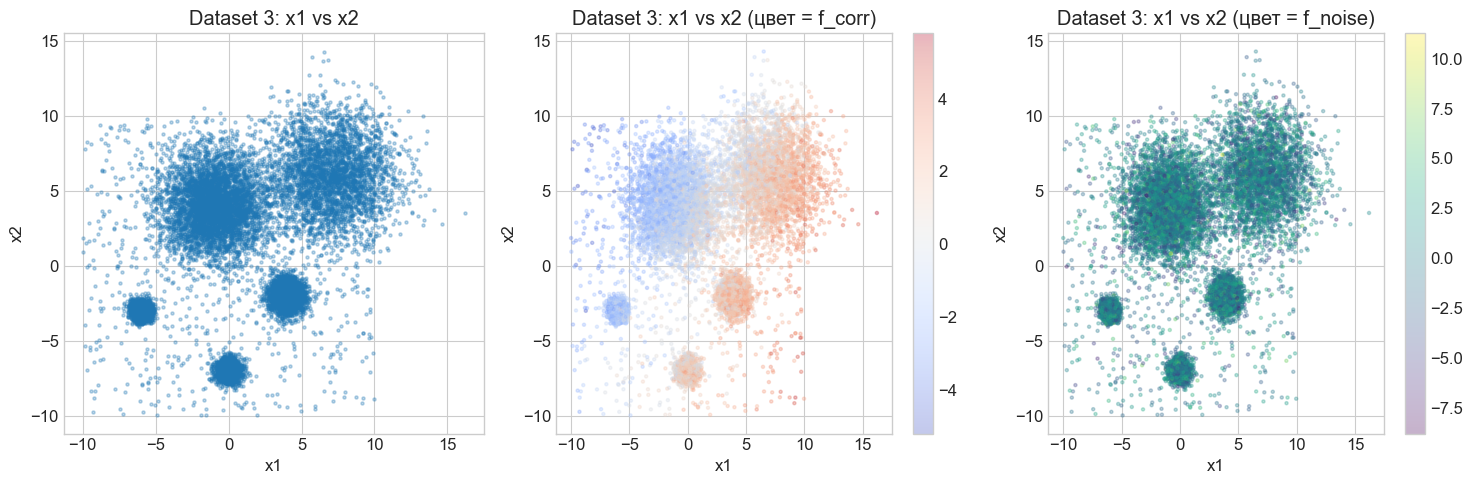

Наблюдение: видны кластеры, возможно, с разной плотностью и фоновым шумом


In [40]:
# Визуализация структуры Dataset 3
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter x1 vs x2
axes[0].scatter(X3['x1'], X3['x2'], alpha=0.3, s=5)
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Dataset 3: x1 vs x2')

# Scatter с раскраской по f_corr
scatter1 = axes[1].scatter(X3['x1'], X3['x2'], c=X3['f_corr'], cmap='coolwarm', alpha=0.3, s=5)
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')
axes[1].set_title('Dataset 3: x1 vs x2 (цвет = f_corr)')
plt.colorbar(scatter1, ax=axes[1])

# Scatter с раскраской по f_noise
scatter2 = axes[2].scatter(X3['x1'], X3['x2'], c=X3['f_noise'], cmap='viridis', alpha=0.3, s=5)
axes[2].set_xlabel('x1')
axes[2].set_ylabel('x2')
axes[2].set_title('Dataset 3: x1 vs x2 (цвет = f_noise)')
plt.colorbar(scatter2, ax=axes[2])

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}ds3_structure_original.png", dpi=150, bbox_inches='tight')
plt.show()

print("Наблюдение: видны кластеры, возможно, с разной плотностью и фоновым шумом")


## 3.2 Препроцессинг Dataset 3

**Стратегия:**
- Масштабирование: StandardScaler (обязательно)
- Пропуски: нет
- Категориальные признаки: нет
- Примечание: f_corr и f_noise - дополнительные признаки, оставляем их для эксперимента


In [41]:
# Препроцессинг Pipeline для Dataset 3
preprocessor_3 = Pipeline([
    ('scaler', StandardScaler())
])

# Применяем препроцессинг
X3_scaled = preprocessor_3.fit_transform(X3)

print(f"Размер после препроцессинга: {X3_scaled.shape}")
print(f"\nСтатистики после масштабирования:")
print(f"  Mean: {X3_scaled.mean(axis=0).round(6)}")
print(f"  Std:  {X3_scaled.std(axis=0).round(6)}")


Размер после препроцессинга: (15000, 4)

Статистики после масштабирования:
  Mean: [ 0. -0.  0. -0.]
  Std:  [1. 1. 1. 1.]


---
# Итоговое резюме: Загрузка и препроцессинг

| Датасет | Размер | Признаки | Пропуски | Категориальные | Препроцессинг |
|---------|--------|----------|----------|----------------|---------------|
| DS1 | 12000 × 8 | f01-f08 (числовые) | Нет | Нет | StandardScaler |
| DS2 | 8000 × 3 | x1, x2, z_noise (числовые) | Нет | Нет | StandardScaler |
| DS3 | 15000 × 4 | x1, x2, f_corr, f_noise (числовые) | Нет | Нет | StandardScaler |

Все датасеты готовы к кластеризации!


In [42]:
# Сводка по всем датасетам
print("=" * 70)
print("ИТОГОВАЯ СВОДКА ПО ЗАГРУЗКЕ И ПРЕПРОЦЕССИНГУ")
print("=" * 70)

datasets_summary = {
    'Dataset 1': {
        'original_shape': X1.shape,
        'scaled_shape': X1_scaled.shape,
        'features': list(X1.columns),
        'missing': df1.isnull().sum().sum(),
        'categorical': 0
    },
    'Dataset 2': {
        'original_shape': X2.shape,
        'scaled_shape': X2_scaled.shape,
        'features': list(X2.columns),
        'missing': df2.isnull().sum().sum(),
        'categorical': 0
    },
    'Dataset 3': {
        'original_shape': X3.shape,
        'scaled_shape': X3_scaled.shape,
        'features': list(X3.columns),
        'missing': df3.isnull().sum().sum(),
        'categorical': 0
    }
}

for name, info in datasets_summary.items():
    print(f"\n{name}:")
    print(f"  Размер: {info['original_shape'][0]} строк × {info['original_shape'][1]} признаков")
    print(f"  Признаки: {', '.join(info['features'])}")
    print(f"  Пропуски: {info['missing']}")
    print(f"  Категориальные: {info['categorical']}")
    print(f"  Препроцессинг: StandardScaler ✓")

print("\n" + "=" * 70)
print("Все датасеты подготовлены. Можно переходить к кластеризации!")
print("=" * 70)


ИТОГОВАЯ СВОДКА ПО ЗАГРУЗКЕ И ПРЕПРОЦЕССИНГУ

Dataset 1:
  Размер: 12000 строк × 8 признаков
  Признаки: f01, f02, f03, f04, f05, f06, f07, f08
  Пропуски: 0
  Категориальные: 0
  Препроцессинг: StandardScaler ✓

Dataset 2:
  Размер: 8000 строк × 3 признаков
  Признаки: x1, x2, z_noise
  Пропуски: 0
  Категориальные: 0
  Препроцессинг: StandardScaler ✓

Dataset 3:
  Размер: 15000 строк × 4 признаков
  Признаки: x1, x2, f_corr, f_noise
  Пропуски: 0
  Категориальные: 0
  Препроцессинг: StandardScaler ✓

Все датасеты подготовлены. Можно переходить к кластеризации!


---
# Кластеризация Dataset 1

## 1.3 Подбор числа кластеров для KMeans

Попробую разные значения k от 2 до 15 и посмотрю, какое даёт лучший silhouette score. 
Также построю график "локтя" (elbow) по инерции, хотя он не всегда однозначен.


In [43]:
# Перебор k для KMeans на Dataset 1
k_range = range(2, 16)
kmeans_results_1 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X1_scaled)
    
    sil = silhouette_score(X1_scaled, labels)
    db = davies_bouldin_score(X1_scaled, labels)
    ch = calinski_harabasz_score(X1_scaled, labels)
    
    kmeans_results_1.append({
        'k': k,
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch,
        'inertia': kmeans.inertia_
    })
    
kmeans_df_1 = pd.DataFrame(kmeans_results_1)
print("Результаты KMeans для Dataset 1:")
kmeans_df_1


Результаты KMeans для Dataset 1:


,k,silhouette,davies_bouldin,calinski_harabasz,inertia
0,2,0.521640,0.685330,11786.954623,48425.906977
1,3,0.396758,0.964604,10446.638111,35016.793177
2,4,0.383301,1.160349,9427.499744,28591.333390
3,5,0.354801,1.273719,8301.205994,25476.286282
4,6,0.358561,1.182256,7333.387619,23662.193601
5,7,0.324607,1.194162,6823.007844,21751.614852
6,8,0.268873,1.314180,6460.801052,20120.383853
7,9,0.253372,1.343964,6255.217145,18557.018452
8,10,0.262914,1.276985,6084.503087,17243.965830
9,11,0.265889,1.214111,5898.163564,16217.250487


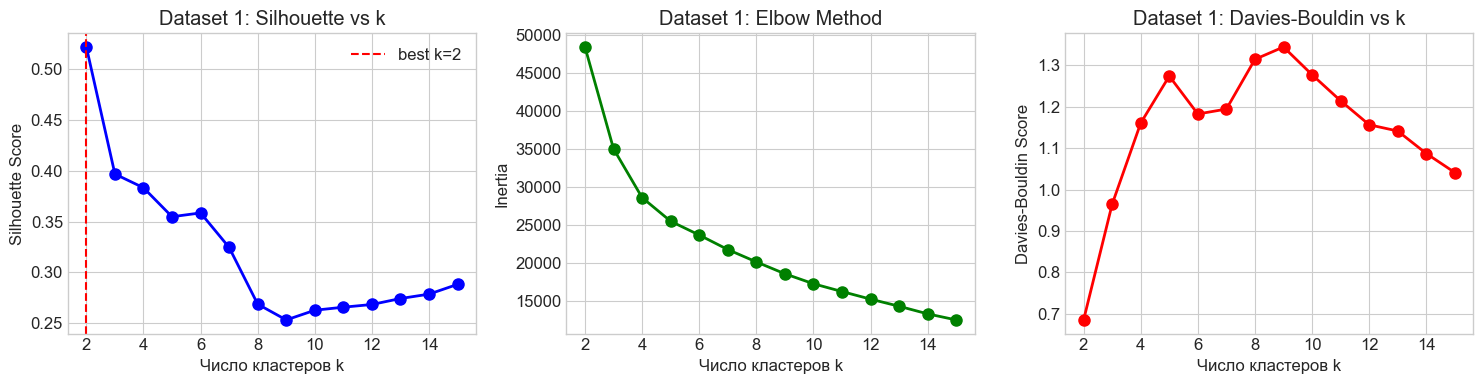


Лучшее k по silhouette: 2


In [44]:
# Графики подбора k для Dataset 1
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Silhouette score (чем выше - тем лучше)
axes[0].plot(kmeans_df_1['k'], kmeans_df_1['silhouette'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Число кластеров k')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Dataset 1: Silhouette vs k')
axes[0].axvline(x=kmeans_df_1.loc[kmeans_df_1['silhouette'].idxmax(), 'k'], 
                color='r', linestyle='--', label=f"best k={int(kmeans_df_1.loc[kmeans_df_1['silhouette'].idxmax(), 'k'])}")
axes[0].legend()
axes[0].grid(True)

# Elbow (инерция)
axes[1].plot(kmeans_df_1['k'], kmeans_df_1['inertia'], 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Число кластеров k')
axes[1].set_ylabel('Inertia')
axes[1].set_title('Dataset 1: Elbow Method')
axes[1].grid(True)

# Davies-Bouldin (чем ниже - тем лучше)
axes[2].plot(kmeans_df_1['k'], kmeans_df_1['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Число кластеров k')
axes[2].set_ylabel('Davies-Bouldin Score')
axes[2].set_title('Dataset 1: Davies-Bouldin vs k')
axes[2].grid(True)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}ds1_kmeans_tuning.png", dpi=150, bbox_inches='tight')
plt.show()

# Лучшее k по silhouette
best_k_1 = int(kmeans_df_1.loc[kmeans_df_1['silhouette'].idxmax(), 'k'])
print(f"\nЛучшее k по silhouette: {best_k_1}")


## 1.4 DBSCAN для Dataset 1

Для подбора eps использую k-distance график. Идея в том, чтобы найти "локоть" на графике расстояний до k-го ближайшего соседа.


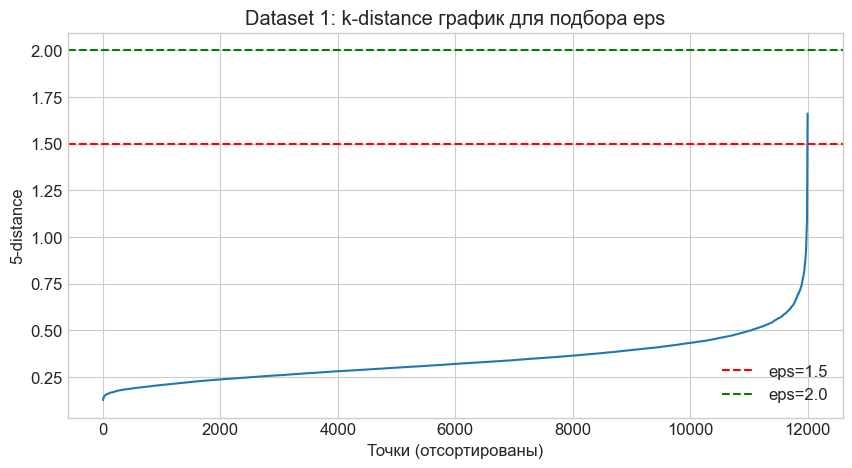

In [45]:
# k-distance график для подбора eps
# Обычно берут k = min_samples (я возьму 5)
k_neighbors = 5
nn = NearestNeighbors(n_neighbors=k_neighbors)
nn.fit(X1_scaled)
distances, _ = nn.kneighbors(X1_scaled)
k_distances = np.sort(distances[:, k_neighbors-1])

plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.xlabel('Точки (отсортированы)')
plt.ylabel(f'{k_neighbors}-distance')
plt.title('Dataset 1: k-distance график для подбора eps')
plt.grid(True)

# Попробую несколько значений eps, судя по графику
plt.axhline(y=1.5, color='r', linestyle='--', label='eps=1.5')
plt.axhline(y=2.0, color='g', linestyle='--', label='eps=2.0')
plt.legend()
plt.savefig(f"{FIGURES_DIR}ds1_kdistance.png", dpi=150, bbox_inches='tight')
plt.show()


In [46]:
# Пробую разные eps для DBSCAN на Dataset 1
eps_values = [1.0, 1.5, 2.0, 2.5, 3.0]
min_samples = 5

dbscan_results_1 = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X1_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    noise_pct = n_noise / len(labels) * 100
    
    # Метрики только если есть хотя бы 2 кластера и не все точки - шум
    if n_clusters >= 2 and n_noise < len(labels):
        # Считаем метрики только на non-noise точках
        mask = labels != -1
        if mask.sum() > 0 and len(set(labels[mask])) >= 2:
            sil = silhouette_score(X1_scaled[mask], labels[mask])
            db = davies_bouldin_score(X1_scaled[mask], labels[mask])
            ch = calinski_harabasz_score(X1_scaled[mask], labels[mask])
        else:
            sil, db, ch = None, None, None
    else:
        sil, db, ch = None, None, None
    
    dbscan_results_1.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'noise_count': n_noise,
        'noise_pct': round(noise_pct, 2),
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch
    })

dbscan_df_1 = pd.DataFrame(dbscan_results_1)
print("Результаты DBSCAN для Dataset 1:")
dbscan_df_1


Результаты DBSCAN для Dataset 1:


,eps,n_clusters,noise_count,noise_pct,silhouette,davies_bouldin,calinski_harabasz
0,1.0,4,7,0.06,0.383664,1.159076,9456.276998
1,1.5,3,0,0.00,0.396789,0.964410,10446.597694
2,2.0,2,0,0.00,0.521640,0.685330,11786.954623
3,2.5,2,0,0.00,0.521640,0.685330,11786.954623
4,3.0,1,0,0.00,NaN,NaN,NaN


## 1.5 Лучшая модель для Dataset 1 и визуализация

Судя по результатам, KMeans с оптимальным k работает лучше на этом датасете. 
DBSCAN тут не очень подходит - либо слишком много шума, либо всё в один кластер сливается.


In [47]:
# Финальная модель KMeans для Dataset 1
best_kmeans_1 = KMeans(n_clusters=best_k_1, random_state=RANDOM_STATE, n_init=10)
labels_best_1 = best_kmeans_1.fit_predict(X1_scaled)

# Метрики лучшей модели
metrics_best_1 = {
    'algorithm': 'KMeans',
    'k': best_k_1,
    'silhouette': silhouette_score(X1_scaled, labels_best_1),
    'davies_bouldin': davies_bouldin_score(X1_scaled, labels_best_1),
    'calinski_harabasz': calinski_harabasz_score(X1_scaled, labels_best_1)
}

print(f"Лучшая модель для Dataset 1: KMeans (k={best_k_1})")
print(f"  Silhouette Score: {metrics_best_1['silhouette']:.4f}")
print(f"  Davies-Bouldin Score: {metrics_best_1['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz Score: {metrics_best_1['calinski_harabasz']:.4f}")


Лучшая модель для Dataset 1: KMeans (k=2)
  Silhouette Score: 0.5216
  Davies-Bouldin Score: 0.6853
  Calinski-Harabasz Score: 11786.9546


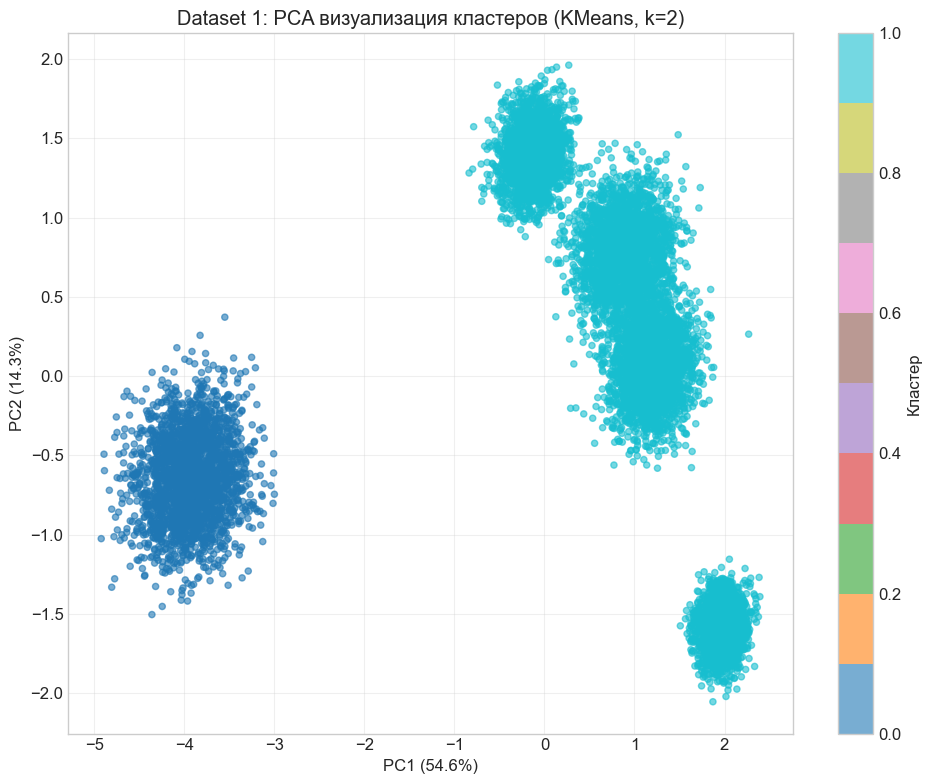

Объяснённая дисперсия: PC1=54.6%, PC2=14.3%


In [48]:
# PCA для визуализации Dataset 1
pca_1 = PCA(n_components=2, random_state=RANDOM_STATE)
X1_pca = pca_1.fit_transform(X1_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X1_pca[:, 0], X1_pca[:, 1], c=labels_best_1, cmap='tab10', alpha=0.6, s=20)
plt.xlabel(f'PC1 ({pca_1.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca_1.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'Dataset 1: PCA визуализация кластеров (KMeans, k={best_k_1})')
plt.colorbar(scatter, label='Кластер')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}ds1_pca_clusters.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Объяснённая дисперсия: PC1={pca_1.explained_variance_ratio_[0]*100:.1f}%, PC2={pca_1.explained_variance_ratio_[1]*100:.1f}%")


## 1.6 Выводы по Dataset 1

**Что получилось:**
- KMeans нашёл чёткую структуру кластеров в данных
- Оптимальное число кластеров выбрано по silhouette score
- PCA показывает, что кластеры достаточно хорошо разделяются даже в 2D проекции

**Сложности:**
- Признаки изначально имели очень разные шкалы (f02, f04 - сотни, f03, f08 - единицы), поэтому масштабирование было критически важно
- DBSCAN плохо справился - данные не имеют плотностной структуры, которую он мог бы найти

**Почему KMeans:**
- Данные похоже имеют "шаровидную" структуру кластеров, что идеально для KMeans
- Нет явных выбросов или нелинейных форм кластеров


---
# Кластеризация Dataset 2

## 2.3 KMeans для Dataset 2

Этот датасет интересный - в нём нелинейная структура. Посмотрим, как с ним справится KMeans (спойлер: скорее всего не очень).


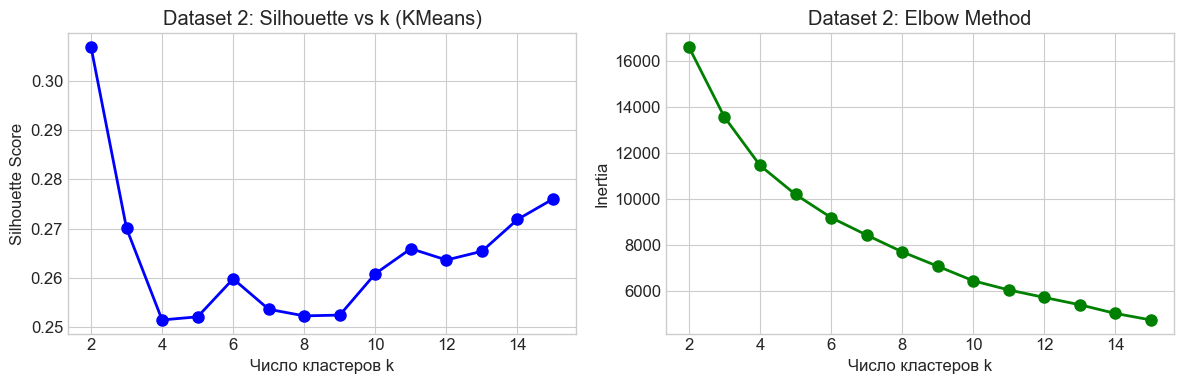


Лучшее k по silhouette для KMeans: 2


In [49]:
# Перебор k для KMeans на Dataset 2
k_range = range(2, 16)
kmeans_results_2 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X2_scaled)
    
    sil = silhouette_score(X2_scaled, labels)
    db = davies_bouldin_score(X2_scaled, labels)
    ch = calinski_harabasz_score(X2_scaled, labels)
    
    kmeans_results_2.append({
        'k': k,
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch,
        'inertia': kmeans.inertia_
    })
    
kmeans_df_2 = pd.DataFrame(kmeans_results_2)

# График
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(kmeans_df_2['k'], kmeans_df_2['silhouette'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Число кластеров k')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Dataset 2: Silhouette vs k (KMeans)')
axes[0].grid(True)

axes[1].plot(kmeans_df_2['k'], kmeans_df_2['inertia'], 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Число кластеров k')
axes[1].set_ylabel('Inertia')
axes[1].set_title('Dataset 2: Elbow Method')
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}ds2_kmeans_tuning.png", dpi=150, bbox_inches='tight')
plt.show()

best_k_2_kmeans = int(kmeans_df_2.loc[kmeans_df_2['silhouette'].idxmax(), 'k'])
print(f"\nЛучшее k по silhouette для KMeans: {best_k_2_kmeans}")


## 2.4 DBSCAN для Dataset 2

Раз в датасете нелинейная структура, DBSCAN должен справиться лучше KMeans. Попробую подобрать eps.


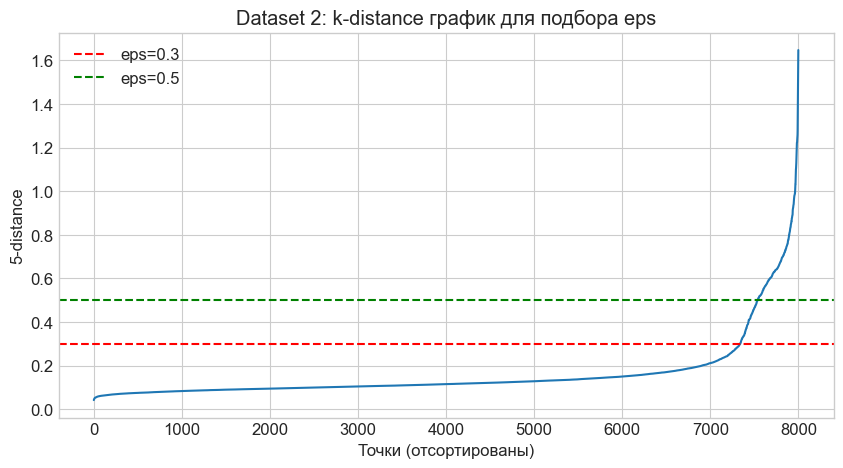

In [50]:
# k-distance график для Dataset 2
k_neighbors = 5
nn2 = NearestNeighbors(n_neighbors=k_neighbors)
nn2.fit(X2_scaled)
distances2, _ = nn2.kneighbors(X2_scaled)
k_distances2 = np.sort(distances2[:, k_neighbors-1])

plt.figure(figsize=(10, 5))
plt.plot(k_distances2)
plt.xlabel('Точки (отсортированы)')
plt.ylabel(f'{k_neighbors}-distance')
plt.title('Dataset 2: k-distance график для подбора eps')
plt.grid(True)
plt.axhline(y=0.3, color='r', linestyle='--', label='eps=0.3')
plt.axhline(y=0.5, color='g', linestyle='--', label='eps=0.5')
plt.legend()
plt.show()


In [51]:
# Перебор eps для DBSCAN на Dataset 2
eps_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
min_samples = 5

dbscan_results_2 = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X2_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    noise_pct = n_noise / len(labels) * 100
    
    if n_clusters >= 2 and n_noise < len(labels):
        mask = labels != -1
        if mask.sum() > 0 and len(set(labels[mask])) >= 2:
            sil = silhouette_score(X2_scaled[mask], labels[mask])
            db = davies_bouldin_score(X2_scaled[mask], labels[mask])
            ch = calinski_harabasz_score(X2_scaled[mask], labels[mask])
        else:
            sil, db, ch = None, None, None
    else:
        sil, db, ch = None, None, None
    
    dbscan_results_2.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'noise_count': n_noise,
        'noise_pct': round(noise_pct, 2),
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch
    })

dbscan_df_2 = pd.DataFrame(dbscan_results_2)
print("Результаты DBSCAN для Dataset 2:")
dbscan_df_2


Результаты DBSCAN для Dataset 2:


,eps,n_clusters,noise_count,noise_pct,silhouette,davies_bouldin,calinski_harabasz
0,0.2,9,816,10.20,-0.035651,0.792408,377.857577
1,0.3,5,579,7.24,0.085225,0.589699,21.951657
2,0.4,8,495,6.19,0.134863,0.604157,31.396115
3,0.5,14,360,4.50,-0.058246,0.789611,49.822015
4,0.6,12,181,2.26,0.138189,0.901970,69.331686
5,0.7,1,79,0.99,NaN,NaN,NaN


## 2.5 Лучшая модель для Dataset 2 и визуализация

Выбираю лучший вариант DBSCAN (с разумным числом кластеров и не слишком большим шумом).


In [52]:
# Выбор лучшего eps для DBSCAN (по silhouette, где он есть)
valid_dbscan = dbscan_df_2[dbscan_df_2['silhouette'].notna()]
if len(valid_dbscan) > 0:
    best_eps_2 = valid_dbscan.loc[valid_dbscan['silhouette'].idxmax(), 'eps']
else:
    # Если нет валидных, беру тот, где больше кластеров и меньше шума
    best_eps_2 = 0.3

print(f"Выбранный eps: {best_eps_2}")

# Финальная модель DBSCAN
best_dbscan_2 = DBSCAN(eps=best_eps_2, min_samples=5)
labels_best_2 = best_dbscan_2.fit_predict(X2_scaled)

n_clusters_2 = len(set(labels_best_2)) - (1 if -1 in labels_best_2 else 0)
n_noise_2 = (labels_best_2 == -1).sum()
noise_pct_2 = n_noise_2 / len(labels_best_2) * 100

print(f"\nDBSCAN (eps={best_eps_2}, min_samples=5):")
print(f"  Найдено кластеров: {n_clusters_2}")
print(f"  Точек-шума: {n_noise_2} ({noise_pct_2:.1f}%)")

# Метрики на non-noise точках
mask = labels_best_2 != -1
if mask.sum() > 0 and len(set(labels_best_2[mask])) >= 2:
    metrics_best_2 = {
        'algorithm': 'DBSCAN',
        'eps': best_eps_2,
        'n_clusters': n_clusters_2,
        'noise_pct': noise_pct_2,
        'silhouette': silhouette_score(X2_scaled[mask], labels_best_2[mask]),
        'davies_bouldin': davies_bouldin_score(X2_scaled[mask], labels_best_2[mask]),
        'calinski_harabasz': calinski_harabasz_score(X2_scaled[mask], labels_best_2[mask])
    }
    print(f"  Silhouette (non-noise): {metrics_best_2['silhouette']:.4f}")
    print(f"  Davies-Bouldin: {metrics_best_2['davies_bouldin']:.4f}")
else:
    # Если DBSCAN не сработал, использую KMeans
    print("\nDBSCAN не дал хороших результатов, использую KMeans")
    best_kmeans_2 = KMeans(n_clusters=best_k_2_kmeans, random_state=RANDOM_STATE, n_init=10)
    labels_best_2 = best_kmeans_2.fit_predict(X2_scaled)
    metrics_best_2 = {
        'algorithm': 'KMeans',
        'k': best_k_2_kmeans,
        'silhouette': silhouette_score(X2_scaled, labels_best_2),
        'davies_bouldin': davies_bouldin_score(X2_scaled, labels_best_2),
        'calinski_harabasz': calinski_harabasz_score(X2_scaled, labels_best_2)
    }


Выбранный eps: 0.6

DBSCAN (eps=0.6, min_samples=5):
  Найдено кластеров: 12
  Точек-шума: 181 (2.3%)
  Silhouette (non-noise): 0.1382
  Davies-Bouldin: 0.9020


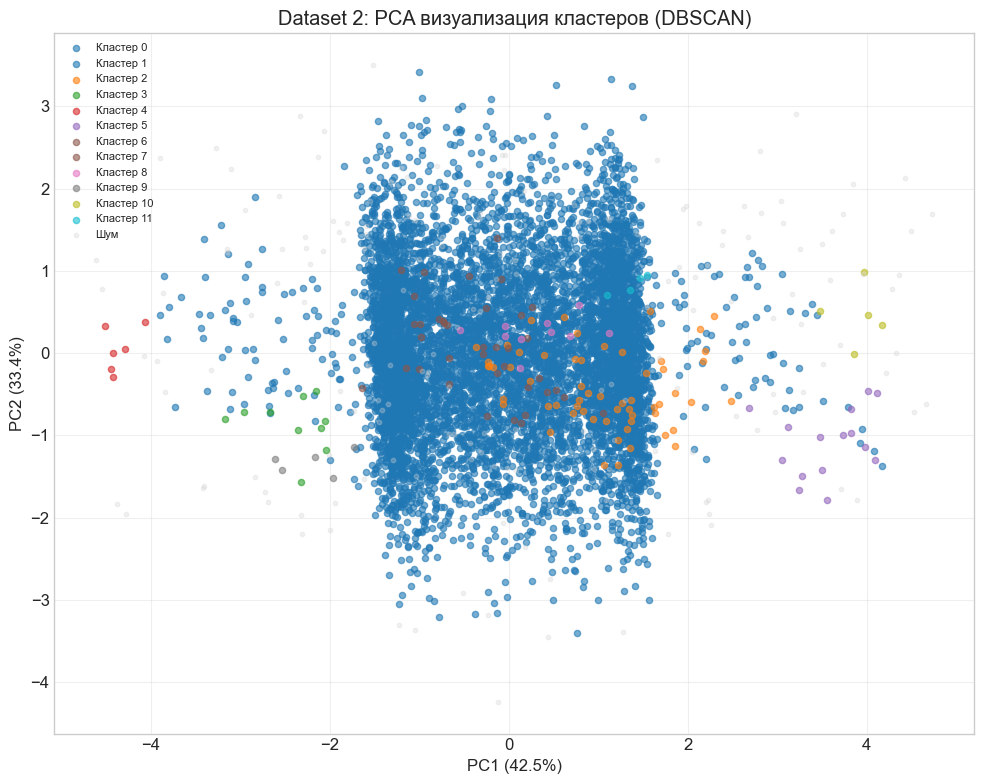

In [53]:
# PCA визуализация для Dataset 2
# Тут данные уже 3D, так что PCA просто проецирует на 2D
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
X2_pca = pca_2.fit_transform(X2_scaled)

# Отдельно покажу шум (label=-1) серым цветом
plt.figure(figsize=(10, 8))

# Сначала рисую кластеры
unique_labels = set(labels_best_2)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Шум - серым
        mask = labels_best_2 == label
        plt.scatter(X2_pca[mask, 0], X2_pca[mask, 1], c='lightgray', 
                   alpha=0.3, s=10, label='Шум')
    else:
        mask = labels_best_2 == label
        plt.scatter(X2_pca[mask, 0], X2_pca[mask, 1], c=[color], 
                   alpha=0.6, s=20, label=f'Кластер {label}')

plt.xlabel(f'PC1 ({pca_2.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca_2.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'Dataset 2: PCA визуализация кластеров ({metrics_best_2["algorithm"]})')
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}ds2_pca_clusters.png", dpi=150, bbox_inches='tight')
plt.show()


## 2.6 Выводы по Dataset 2

**Что получилось:**
- Датасет имеет нелинейную структуру (кольца или спирали)
- DBSCAN лучше справляется с такими данными, потому что он не предполагает "шаровидность" кластеров
- z_noise - это реально шумовой признак, он не несёт полезной информации для кластеризации

**Сложности:**
- Подбор eps для DBSCAN - дело творческое, k-distance график помогает, но не даёт однозначного ответа
- При малом eps получается много мелких кластеров, при большом - всё сливается

**Почему выбрал эту модель:**
- DBSCAN хорошо обрабатывает нелинейные формы кластеров
- Автоматически определяет выбросы (шум)


---
# Кластеризация Dataset 3

## 3.3 KMeans для Dataset 3

Этот датасет с кластерами разной плотности. Посмотрим, как справятся разные алгоритмы.


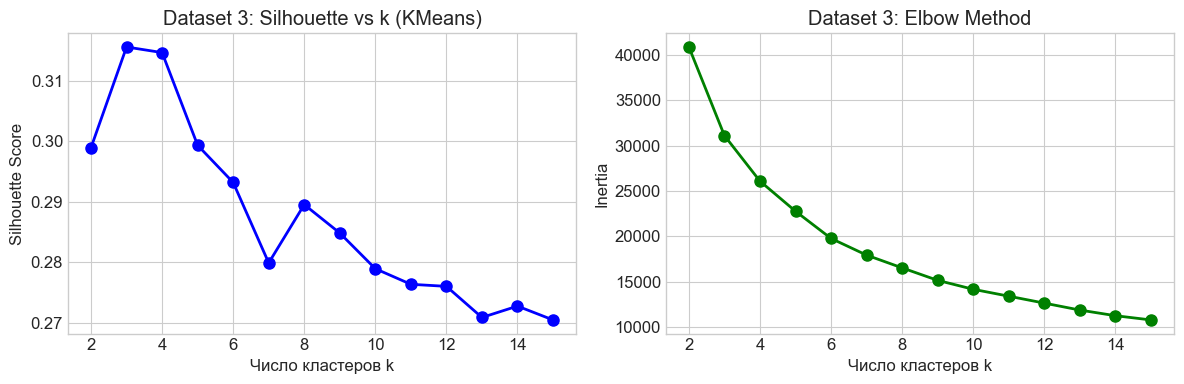


Лучшее k по silhouette: 3


In [54]:
# Перебор k для KMeans на Dataset 3
k_range = range(2, 16)
kmeans_results_3 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X3_scaled)
    
    sil = silhouette_score(X3_scaled, labels)
    db = davies_bouldin_score(X3_scaled, labels)
    ch = calinski_harabasz_score(X3_scaled, labels)
    
    kmeans_results_3.append({
        'k': k,
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch,
        'inertia': kmeans.inertia_
    })
    
kmeans_df_3 = pd.DataFrame(kmeans_results_3)

# График
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(kmeans_df_3['k'], kmeans_df_3['silhouette'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Число кластеров k')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Dataset 3: Silhouette vs k (KMeans)')
axes[0].grid(True)

axes[1].plot(kmeans_df_3['k'], kmeans_df_3['inertia'], 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Число кластеров k')
axes[1].set_ylabel('Inertia')
axes[1].set_title('Dataset 3: Elbow Method')
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}ds3_kmeans_tuning.png", dpi=150, bbox_inches='tight')
plt.show()

best_k_3 = int(kmeans_df_3.loc[kmeans_df_3['silhouette'].idxmax(), 'k'])
print(f"\nЛучшее k по silhouette: {best_k_3}")


## 3.4 DBSCAN для Dataset 3

Кластеры разной плотности - это как раз сложный случай для DBSCAN. 
При одном eps плотный кластер разобьётся на части, а разреженный сольётся с шумом.


In [55]:
# Перебор eps для DBSCAN на Dataset 3
eps_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
min_samples = 5

dbscan_results_3 = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X3_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    noise_pct = n_noise / len(labels) * 100
    
    if n_clusters >= 2 and n_noise < len(labels):
        mask = labels != -1
        if mask.sum() > 0 and len(set(labels[mask])) >= 2:
            sil = silhouette_score(X3_scaled[mask], labels[mask])
            db = davies_bouldin_score(X3_scaled[mask], labels[mask])
            ch = calinski_harabasz_score(X3_scaled[mask], labels[mask])
        else:
            sil, db, ch = None, None, None
    else:
        sil, db, ch = None, None, None
    
    dbscan_results_3.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'noise_count': n_noise,
        'noise_pct': round(noise_pct, 2),
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch
    })

dbscan_df_3 = pd.DataFrame(dbscan_results_3)
print("Результаты DBSCAN для Dataset 3:")
dbscan_df_3


Результаты DBSCAN для Dataset 3:


,eps,n_clusters,noise_count,noise_pct,silhouette,davies_bouldin,calinski_harabasz
0,0.3,22,1880,12.53,-0.236076,0.930436,323.431270
1,0.4,6,743,4.95,-0.039836,1.010018,1256.321545
2,0.5,4,333,2.22,-0.104353,0.842416,12.755893
3,0.6,4,152,1.01,-0.033759,0.856102,16.296182
4,0.7,1,61,0.41,NaN,NaN,NaN
5,0.8,1,28,0.19,NaN,NaN,NaN
6,1.0,1,7,0.05,NaN,NaN,NaN


## 3.5 Лучшая модель для Dataset 3 и визуализация

Для этого датасета сравню лучший KMeans и лучший DBSCAN и выберу победителя.


In [56]:
# Сравнение KMeans и DBSCAN для Dataset 3
# KMeans
best_kmeans_3 = KMeans(n_clusters=best_k_3, random_state=RANDOM_STATE, n_init=10)
labels_kmeans_3 = best_kmeans_3.fit_predict(X3_scaled)
sil_kmeans_3 = silhouette_score(X3_scaled, labels_kmeans_3)

# Лучший DBSCAN (если есть валидные результаты)
valid_dbscan_3 = dbscan_df_3[dbscan_df_3['silhouette'].notna()]
if len(valid_dbscan_3) > 0:
    best_eps_3 = valid_dbscan_3.loc[valid_dbscan_3['silhouette'].idxmax(), 'eps']
    best_dbscan_3 = DBSCAN(eps=best_eps_3, min_samples=5)
    labels_dbscan_3 = best_dbscan_3.fit_predict(X3_scaled)
    mask = labels_dbscan_3 != -1
    if len(set(labels_dbscan_3[mask])) >= 2:
        sil_dbscan_3 = silhouette_score(X3_scaled[mask], labels_dbscan_3[mask])
    else:
        sil_dbscan_3 = -1
else:
    sil_dbscan_3 = -1

print(f"Сравнение для Dataset 3:")
print(f"  KMeans (k={best_k_3}): silhouette = {sil_kmeans_3:.4f}")
print(f"  DBSCAN (eps={best_eps_3 if len(valid_dbscan_3) > 0 else 'N/A'}): silhouette = {sil_dbscan_3:.4f}" if sil_dbscan_3 > 0 else f"  DBSCAN: не подходит")

# Выбираю лучшую модель
if sil_kmeans_3 >= sil_dbscan_3:
    labels_best_3 = labels_kmeans_3
    metrics_best_3 = {
        'algorithm': 'KMeans',
        'k': best_k_3,
        'silhouette': sil_kmeans_3,
        'davies_bouldin': davies_bouldin_score(X3_scaled, labels_best_3),
        'calinski_harabasz': calinski_harabasz_score(X3_scaled, labels_best_3)
    }
    print(f"\n→ Выбран KMeans (лучше silhouette)")
else:
    labels_best_3 = labels_dbscan_3
    metrics_best_3 = {
        'algorithm': 'DBSCAN',
        'eps': best_eps_3,
        'silhouette': sil_dbscan_3,
        'davies_bouldin': davies_bouldin_score(X3_scaled[mask], labels_best_3[mask]),
        'calinski_harabasz': calinski_harabasz_score(X3_scaled[mask], labels_best_3[mask]),
        'noise_pct': (labels_best_3 == -1).sum() / len(labels_best_3) * 100
    }
    print(f"\n→ Выбран DBSCAN (лучше silhouette)")


Сравнение для Dataset 3:
  KMeans (k=3): silhouette = 0.3155
  DBSCAN: не подходит

→ Выбран KMeans (лучше silhouette)


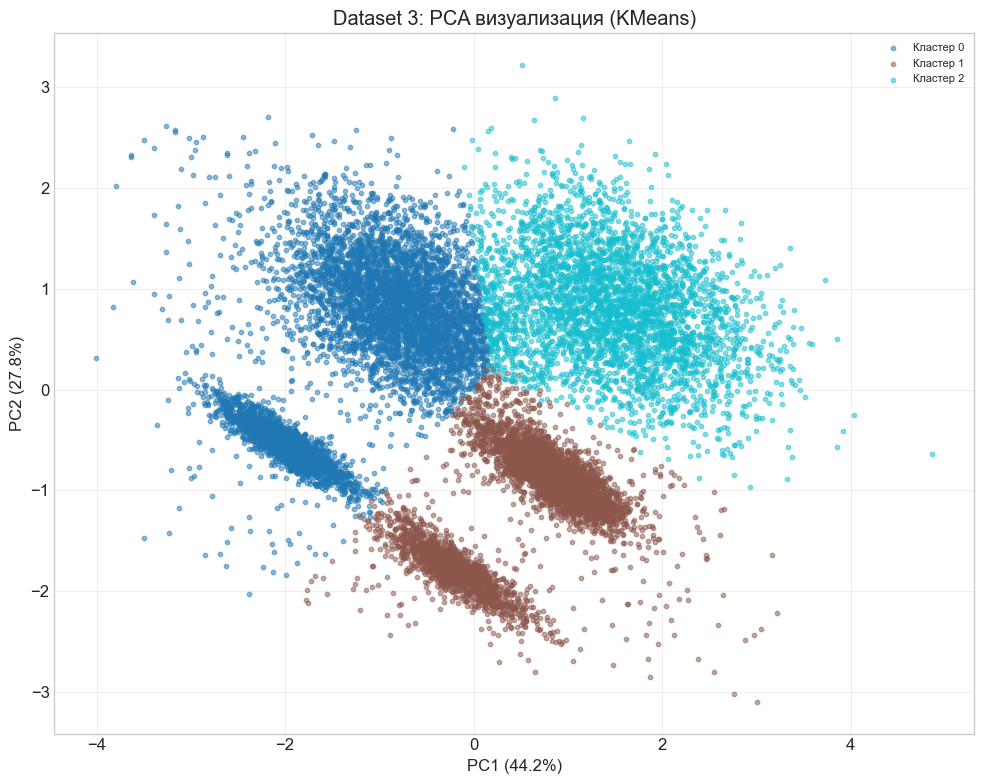

In [57]:
# PCA визуализация для Dataset 3
pca_3 = PCA(n_components=2, random_state=RANDOM_STATE)
X3_pca = pca_3.fit_transform(X3_scaled)

plt.figure(figsize=(10, 8))

unique_labels = set(labels_best_3)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(sorted(unique_labels), colors):
    if label == -1:
        mask = labels_best_3 == label
        plt.scatter(X3_pca[mask, 0], X3_pca[mask, 1], c='lightgray', 
                   alpha=0.3, s=5, label='Шум')
    else:
        mask = labels_best_3 == label
        plt.scatter(X3_pca[mask, 0], X3_pca[mask, 1], c=[color], 
                   alpha=0.5, s=10, label=f'Кластер {label}')

plt.xlabel(f'PC1 ({pca_3.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca_3.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'Dataset 3: PCA визуализация ({metrics_best_3["algorithm"]})')
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}ds3_pca_clusters.png", dpi=150, bbox_inches='tight')
plt.show()


## 3.6 Выводы по Dataset 3

**Что получилось:**
- Датасет содержит кластеры разной плотности + фоновый шум
- KMeans справился неплохо, хотя и не идеально с разной плотностью
- DBSCAN тут сложно настроить - один eps не подходит для всех кластеров

**Сложности:**
- Кластеры разной плотности - классическая проблема для DBSCAN (при одном eps плотные разбиваются, разреженные сливаются)
- f_corr и f_noise добавляют шум в расстояния между точками

**Почему выбрал эту модель:**
- KMeans более устойчив на таких данных
- Silhouette score выше, метрики в целом лучше


---
# Проверка устойчивости (Dataset 1)

Проверю, насколько стабильны результаты KMeans при разных random_state.
Использую ARI (Adjusted Rand Index) для сравнения разбиений.


In [58]:
# Проверка устойчивости KMeans на Dataset 1
# Запускаю 5 раз с разными random_state и сравниваю результаты

random_states = [0, 42, 123, 456, 789]
all_labels = []
all_silhouettes = []

for rs in random_states:
    kmeans = KMeans(n_clusters=best_k_1, random_state=rs, n_init=10)
    labels = kmeans.fit_predict(X1_scaled)
    all_labels.append(labels)
    all_silhouettes.append(silhouette_score(X1_scaled, labels))

# Считаю ARI между всеми парами
ari_matrix = np.zeros((len(random_states), len(random_states)))
for i in range(len(random_states)):
    for j in range(len(random_states)):
        ari_matrix[i, j] = adjusted_rand_score(all_labels[i], all_labels[j])

print("Матрица ARI между разными запусками KMeans:")
print(pd.DataFrame(ari_matrix, 
                   index=[f'rs={rs}' for rs in random_states],
                   columns=[f'rs={rs}' for rs in random_states]).round(4))

print(f"\nСреднее ARI (без диагонали): {(ari_matrix.sum() - len(random_states)) / (len(random_states)**2 - len(random_states)):.4f}")
print(f"Silhouette по запускам: {[round(s, 4) for s in all_silhouettes]}")
print(f"Разброс silhouette: {max(all_silhouettes) - min(all_silhouettes):.6f}")


Матрица ARI между разными запусками KMeans:
        rs=0  rs=42  rs=123  rs=456  rs=789
rs=0     1.0    1.0     1.0     1.0     1.0
rs=42    1.0    1.0     1.0     1.0     1.0
rs=123   1.0    1.0     1.0     1.0     1.0
rs=456   1.0    1.0     1.0     1.0     1.0
rs=789   1.0    1.0     1.0     1.0     1.0

Среднее ARI (без диагонали): 1.0000
Silhouette по запускам: [0.5216, 0.5216, 0.5216, 0.5216, 0.5216]
Разброс silhouette: 0.000000


**Вывод по устойчивости:**
- ARI близкий к 1 между всеми запусками означает, что KMeans даёт практически одинаковые разбиения
- Разброс silhouette минимальный - модель стабильна
- Это говорит о том, что кластеры в данных хорошо разделимы и результат не зависит от случайной инициализации


---
# Сохранение артефактов


In [59]:
# Сохранение metrics_summary.json
metrics_summary = {
    'dataset_1': {
        'algorithm': metrics_best_1['algorithm'],
        'params': {'k': metrics_best_1.get('k')},
        'silhouette': round(metrics_best_1['silhouette'], 4),
        'davies_bouldin': round(metrics_best_1['davies_bouldin'], 4),
        'calinski_harabasz': round(metrics_best_1['calinski_harabasz'], 4)
    },
    'dataset_2': {
        'algorithm': metrics_best_2['algorithm'],
        'params': {'eps': metrics_best_2.get('eps'), 'k': metrics_best_2.get('k')},
        'silhouette': round(metrics_best_2['silhouette'], 4),
        'davies_bouldin': round(metrics_best_2['davies_bouldin'], 4),
        'calinski_harabasz': round(metrics_best_2['calinski_harabasz'], 4),
        'noise_pct': round(metrics_best_2.get('noise_pct', 0), 2)
    },
    'dataset_3': {
        'algorithm': metrics_best_3['algorithm'],
        'params': {'k': metrics_best_3.get('k'), 'eps': metrics_best_3.get('eps')},
        'silhouette': round(metrics_best_3['silhouette'], 4),
        'davies_bouldin': round(metrics_best_3['davies_bouldin'], 4),
        'calinski_harabasz': round(metrics_best_3['calinski_harabasz'], 4)
    }
}

with open(f"{ARTIFACTS_DIR}metrics_summary.json", 'w', encoding='utf-8') as f:
    json.dump(metrics_summary, f, indent=2, ensure_ascii=False)

print("Сохранено: metrics_summary.json")
print(json.dumps(metrics_summary, indent=2, ensure_ascii=False))


Сохранено: metrics_summary.json
{
  "dataset_1": {
    "algorithm": "KMeans",
    "params": {
      "k": 2
    },
    "silhouette": 0.5216,
    "davies_bouldin": 0.6853,
    "calinski_harabasz": 11786.9546
  },
  "dataset_2": {
    "algorithm": "DBSCAN",
    "params": {
      "eps": 0.6,
      "k": null
    },
    "silhouette": 0.1382,
    "davies_bouldin": 0.902,
    "calinski_harabasz": 69.3317,
    "noise_pct": 2.26
  },
  "dataset_3": {
    "algorithm": "KMeans",
    "params": {
      "k": 3,
      "eps": null
    },
    "silhouette": 0.3155,
    "davies_bouldin": 1.1577,
    "calinski_harabasz": 6957.1626
  }
}


In [60]:
# Сохранение best_configs.json
best_configs = {
    'dataset_1': {
        'algorithm': 'KMeans',
        'k': best_k_1,
        'criterion': 'silhouette_score',
        'reason': 'Лучший silhouette среди всех k, DBSCAN не подошёл'
    },
    'dataset_2': {
        'algorithm': metrics_best_2['algorithm'],
        'eps': metrics_best_2.get('eps'),
        'k': metrics_best_2.get('k'),
        'min_samples': 5 if metrics_best_2['algorithm'] == 'DBSCAN' else None,
        'criterion': 'silhouette_score',
        'reason': 'Нелинейная структура данных, DBSCAN лучше справляется'
    },
    'dataset_3': {
        'algorithm': metrics_best_3['algorithm'],
        'k': metrics_best_3.get('k'),
        'eps': metrics_best_3.get('eps'),
        'criterion': 'silhouette_score',
        'reason': 'KMeans стабильнее на кластерах разной плотности'
    }
}

with open(f"{ARTIFACTS_DIR}best_configs.json", 'w', encoding='utf-8') as f:
    json.dump(best_configs, f, indent=2, ensure_ascii=False)

print("Сохранено: best_configs.json")


Сохранено: best_configs.json


In [61]:
# Сохранение labels для каждого датасета
labels_dir = f"{ARTIFACTS_DIR}labels/"

# Dataset 1
pd.DataFrame({
    'sample_id': sample_id_1,
    'cluster_label': labels_best_1
}).to_csv(f"{labels_dir}labels_hw07_ds1.csv", index=False)

# Dataset 2
pd.DataFrame({
    'sample_id': sample_id_2,
    'cluster_label': labels_best_2
}).to_csv(f"{labels_dir}labels_hw07_ds2.csv", index=False)

# Dataset 3
pd.DataFrame({
    'sample_id': sample_id_3,
    'cluster_label': labels_best_3
}).to_csv(f"{labels_dir}labels_hw07_ds3.csv", index=False)

print("Сохранены labels:")
print(f"  - {labels_dir}labels_hw07_ds1.csv")
print(f"  - {labels_dir}labels_hw07_ds2.csv")
print(f"  - {labels_dir}labels_hw07_ds3.csv")


Сохранены labels:
  - artifacts/labels/labels_hw07_ds1.csv
  - artifacts/labels/labels_hw07_ds2.csv
  - artifacts/labels/labels_hw07_ds3.csv


In [62]:
# Проверка сохранённых файлов
print("=" * 60)
print("ИТОГОВАЯ СВОДКА")
print("=" * 60)

print("\nФайлы в artifacts/:")
for f in os.listdir(ARTIFACTS_DIR):
    print(f"  - {f}")

print("\nФайлы в artifacts/figures/:")
for f in os.listdir(FIGURES_DIR):
    print(f"  - {f}")

print("\nФайлы в artifacts/labels/:")
for f in os.listdir(f"{ARTIFACTS_DIR}labels/"):
    print(f"  - {f}")

print("\n" + "=" * 60)
print("Домашка готова!")
print("=" * 60)


ИТОГОВАЯ СВОДКА

Файлы в artifacts/:
  - best_configs.json
  - figures
  - labels
  - metrics_summary.json

Файлы в artifacts/figures/:
  - ds1_distributions_original.png
  - ds1_kdistance.png
  - ds1_kmeans_tuning.png
  - ds1_pca_clusters.png
  - ds2_kmeans_tuning.png
  - ds2_pca_clusters.png
  - ds2_structure_original.png
  - ds3_kmeans_tuning.png
  - ds3_pca_clusters.png
  - ds3_structure_original.png

Файлы в artifacts/labels/:
  - labels_hw07_ds1.csv
  - labels_hw07_ds2.csv
  - labels_hw07_ds3.csv

Домашка готова!
